In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
import bnlearn as bn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Re-read the data to start fresh
train = pd.read_csv('train.csv').set_index('PassengerId')
test = pd.read_csv('test.csv').set_index('PassengerId')

# Drop old features
drop_list = ['Name', 'Age','Cabin', 'Ticket', 'Fare']
train.drop(columns=drop_list, inplace=True)
test.drop(columns=drop_list, inplace=True)

# Convert categorical features to one-hot encoding
dfhot_train, dfnum_train = bn.df2onehot(train)
dfhot_test, dfnum_test = bn.df2onehot(test)


[df2onehot] >Auto detecting dtypes.


100%|██████████| 6/6 [00:00<00:00, 89.63it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████| 6/6 [00:00<00:00, 181.78it/s]


[df2onehot] >Total onehot features: 18

[df2onehot] >Auto detecting dtypes.


100%|██████████| 5/5 [00:00<00:00, 212.24it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████| 5/5 [00:00<00:00, 341.48it/s]

[df2onehot] >Total onehot features: 14


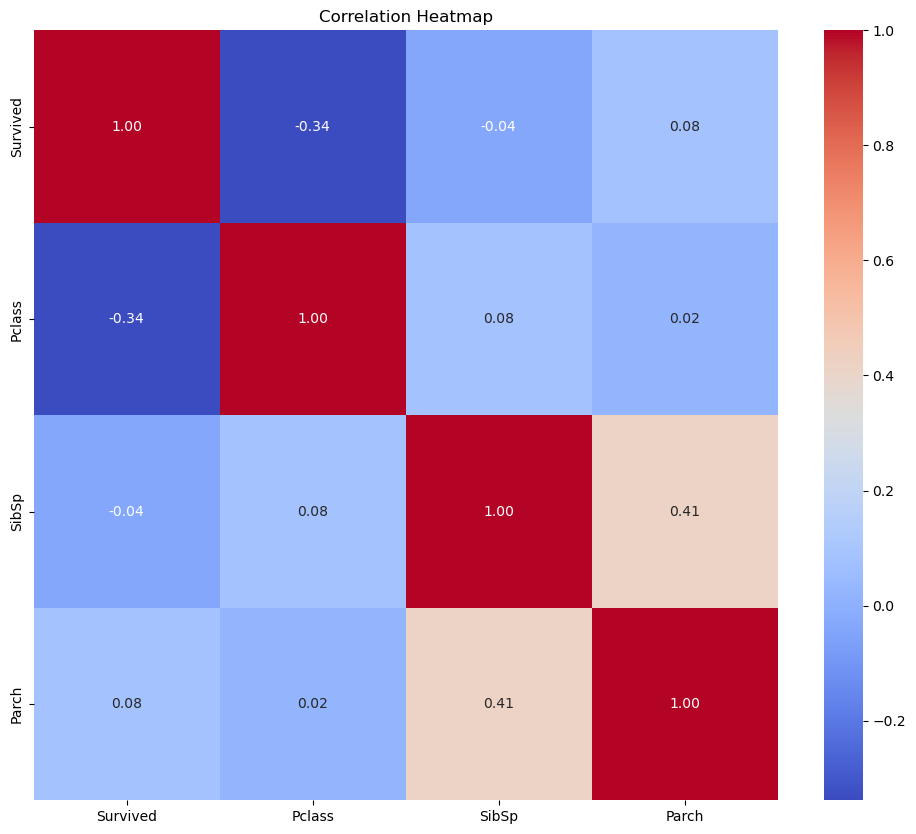

In [16]:
# Heatmap of the numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [11]:
dfnum_target = dfnum_train.pop('Survived')
Xtrain, Xval, Ztrain, Zval = train_test_split(dfnum_train, dfnum_target, test_size=0.2, random_state=0)
valid = pd.concat([Xval, Zval], axis='columns')
dfnum = pd.concat([Xtrain, Ztrain], axis='columns')

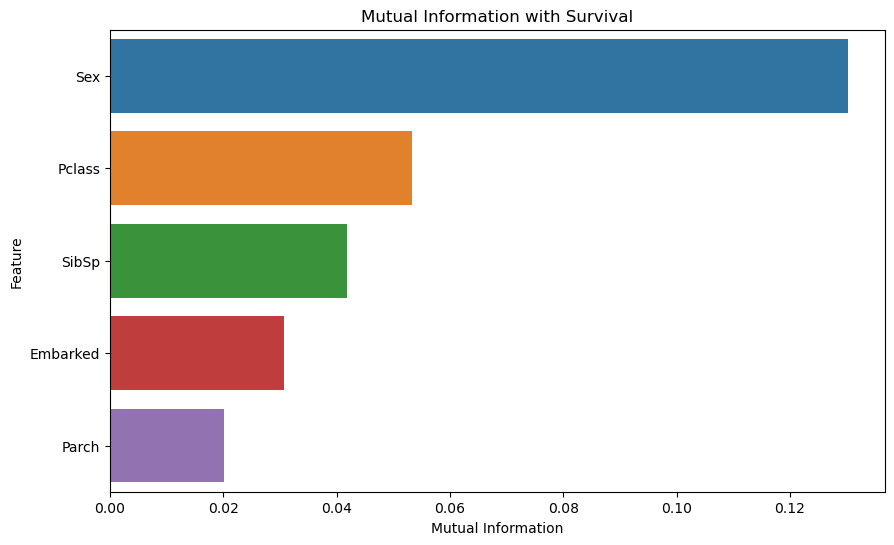

In [12]:
# Compute mutual information
mi = mutual_info_classif(dfnum_train, dfnum_target)
mi_df = pd.DataFrame({'Feature': dfnum_train.columns, 'Mutual Information': mi})
mi_df.sort_values(by='Mutual Information', ascending=False, inplace=True)

# Plotting mutual information
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Mutual Information with Survival')
plt.show()

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


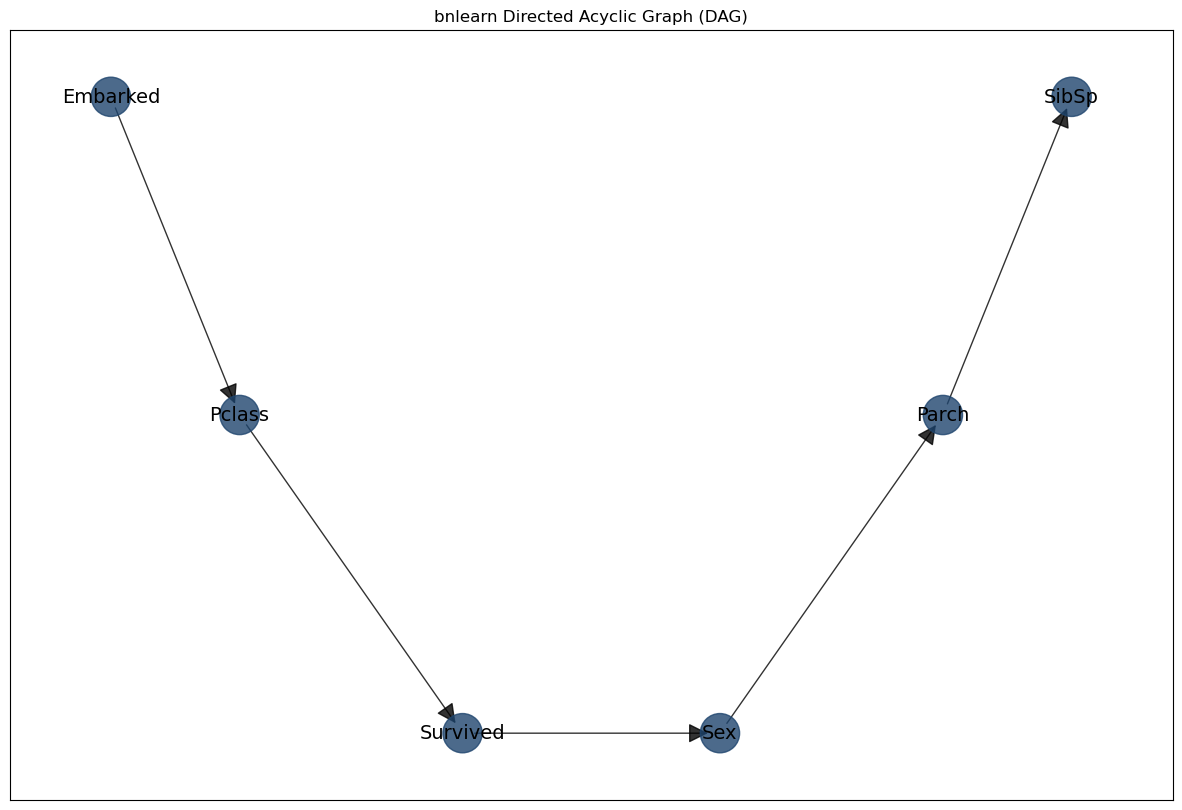

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Pclass:
+-----------+---------------------+-----+---------------------+
| Embarked  | Embarked(0)         | ... | Embarked(3)         |
+-----------+---------------------+-----+---------------------+
| Pclass(1) | 0.3386243386243386  | ... | 0.24554541503694044 |
+-----------+---------------------+-----+---------------------+
| Pclass(2) | 0.33068783068783064 | ... | 0.27553237722729246 |
+-----------+---------------------+-----+---------------------+
| Pclass(3) | 0.33068783068783064 | ... | 0.47892220773576705 |
+-----------+---------------------+-----+---------------------+
[bnlearn] >CPD of Survived:
+-------------+--------------------+--------------------+--------------------+
| Pclass      | Pclass(1)          | Pclass(2)          | Pclass(3)          |
+-------------+---

In [13]:
# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='hc', root_node='Survived', bw_list_method='nodes', verbose=3)

# Plot
G = bn.plot(DAG)

# Parameter learning
model = bn.parameter_learning.fit(DAG, dfnum, verbose=3);

In [14]:
# Make inference
query = bn.inference.fit(model, variables=['Survived'], evidence={'Sex':True, 'Pclass':True})
print(query)
print(query.df)

# Another inference using only sex for evidence
q1 = bn.inference.fit(model, variables=['Survived'], evidence={'Sex':0})
print(query)
print(query.df)

# Print model
bn.print_CPD(model)

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    |   Survived |        p |
+====+============+==========+
|  0 |          0 | 0.566487 |
+----+------------+----------+
|  1 |          1 | 0.433513 |
+----+------------+----------+
+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.5665 |
+-------------+-----------------+
| Survived(1) |          0.4335 |
+-------------+-----------------+
   Survived         p
0         0  0.566487
1         1  0.433513
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    |   Survived |        p |
+====+============+==========+
|  0 |          0 | 0.419009 |
+----+------------+----------+
|  1 |          1 | 0.580991 |
+----+------------+--

{'Pclass':     Pclass  Embarked         p
 0        1         0  0.338624
 1        1         1  0.383465
 2        1         2  0.268577
 3        1         3  0.245545
 4        2         0  0.330688
 5        2         1  0.259455
 6        2         2  0.274947
 7        2         3  0.275532
 8        3         0  0.330688
 9        3         1  0.357080
 10       3         2  0.456476
 11       3         3  0.478922,
 'Survived':    Survived  Pclass         p
 0         0       1  0.462252
 1         0       2  0.508345
 2         0       3  0.634369
 3         1       1  0.537748
 4         1       2  0.491655
 5         1       3  0.365631,
 'Sex':    Sex  Survived         p
 0    0         0  0.333333
 1    0         1  0.561449
 2    1         0  0.666667
 3    1         1  0.438551,
 'Parch':    Parch  Sex         p
 0      0    0  0.179384
 1      0    1  0.133679
 2      1    0  0.369478
 3      1    1  0.532642
 4      2    0  0.230254
 5      2    1  0.176166
 6      3  

In [15]:
Pout = bn.predict(model, df=dfnum_test, variables=['Survived'])

[bnlearn]> Remaining columns for inference: 5


100%|██████████| 84/84 [00:00<00:00, 772.61it/s]


In [17]:
submission = pd.read_csv('gender_submission.csv')
y = submission.drop(columns = 'PassengerId')
submission['Survived'] = Pout['Survived']
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [18]:
accuracy_score(y['Survived'],Pout['Survived'])

0.8277511961722488

In [19]:
print(classification_report(y['Survived'],Pout['Survived']))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       266
           1       1.00      0.53      0.69       152

    accuracy                           0.83       418
   macro avg       0.89      0.76      0.79       418
weighted avg       0.86      0.83      0.81       418

